import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
# CE-40717: Machine Learning

## HW4-MultiLayer Perceptron (MLP)

The following lines of code will load the [MNIST](http://yann.lecun.com/exdb/mnist/) data and turn them
into numpy arrays, you can print their shape if you like.
You can also transform the data as you wish, including seperating
the training data for cross validation.

If you have the data (on google drive or locally) change the root
address accordingly, if you don't, set download=True but you might encounter
some problems downloading the data.

In [1]:
# Amir Pourmand (99210259)

import torchvision.datasets as ds
from sklearn.utils import shuffle
import numpy as np
import pandas as pd

data_train = np.array(ds.MNIST(root="./data", train=True, download=True).data)
target_train = np.array(ds.MNIST(root="./data", train=True, download=True).targets)
data_test = np.array(ds.MNIST(root="./data", train=False, download=True).data)
target_test = np.array(ds.MNIST(root="./data", train=False, download=True).targets)

#data_train, target_train = shuffle(data_train, target_train)

#### Transform the data! ####
data_train =data_train / 255
data_test = data_test / 255

target_train=pd.get_dummies(target_train).values
target_test = pd.get_dummies(target_test).values

data_train=data_train.reshape((-1,28*28))
data_test = data_test.reshape((-1,28*28))


In [2]:
from IPython.core.debugger import set_trace


### Part1:
Complete the functions of the MLP class to create
a MultiLayer Perceptron

In [13]:
def sigmoid(x, derivative=False):
    if derivative:
        return (np.exp(-x))/((np.exp(-x)+1)**2)
    return 1/(1 + np.exp(-x))

def softmax(x):
    exps = np.exp(x - x.max())
    return exps / np.sum(exps, axis=0)

def ReLU(x,derivative=False):
    if derivative:
        return x>0
    return x * (x>0)

def safe_ln(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))

def calculate_accuracy(prediction,real):
    predictedNumber = np.argmax(prediction,axis=0)
    realNumber = np.argmax(real,axis=0)
    return np.mean(predictedNumber == realNumber)

In [4]:
class MLP:
    def __init__(self, in_dimensions, hidden_dimensions, out_dimensions):
        self.w1 = np.random.normal(size=(hidden_dimensions, in_dimensions)) / np.sqrt(hidden_dimensions)
        self.b1 = np.random.normal(size=(hidden_dimensions,1)) / np.sqrt(hidden_dimensions)
        self.w2 = np.random.normal(size=(out_dimensions,hidden_dimensions)) /np.sqrt(out_dimensions)
        self.b2 = np.random.normal(size=(out_dimensions,1))  /np.sqrt(out_dimensions)

    def compute_loss(self,Y):
        Y_hat = self.a2
        L_sum = np.sum(np.multiply(Y, np.log(Y_hat+1e-10)))
        m = Y.shape[1]
        L = -(1/m) * L_sum
        return L
    
    def forward(self, x):
        # perform a forward pass of the network and return the result
        # remember to retain the value of each node (i.e. self.h1_forward)
        # in order to use in backpropagation
        # Use whatever activation function you wish for the first layer
        # and softmax activation for the output layer
        self.a0 = x.T
        
        self.z1 = self.w1 @ self.a0 + self.b1
        self.a1 = ReLU(self.z1,derivative=False)
        
        self.z2 = self.w2 @ self.a1 + self.b2
        self.a2 = softmax(self.z2)
        return self.a2

    def backward(self, y_target,batch_size):
        # perform backpropagation on the loss value and compute the gradient 
        # w.r.t. every element of the network and retain them (i.e. self.w1_backward)
        dZ2 = self.a2 - y_target
        
        self.w2_backward = (1./batch_size) * dZ2 @ self.a1.T
        self.b2_backward = (1./batch_size) * np.sum(dZ2)
        
        dA1 = self.w2.T @ dZ2
        dZ1 = dA1 * ReLU(self.z1,derivative=True)
        
        self.w1_backward = (1./batch_size) * dZ1 @ self.a0.T
        self.b1_backward = (1./batch_size) * np.sum(dZ1)
        

    def step(self, lr, lam):
        # simply update all the weights using the gradinets computed in backward
        # and the given learning rate with SGD
        # don't forget to use regularization
        self.w2 = self.w2 - (lr * self.w2_backward - self.w2*lam*lr)
        self.b2 = self.b2 - (lr * self.b2_backward - self.b2*lam*lr)
        
        self.w1 = self.w1 - (lr * self.w1_backward - self.w1*lam*lr)
        self.b1 = self.b1 - (lr * self.b1_backward - self.b1*lam*lr)
    


### Part2:
Make instances of your network and train them **using l2 regularization and choose the lambda using k-fold cross validation
(set the candidate lambda as you wish)**.

You may choose the hyperparameters (i.e. num of epochs, learning rate etc.)
as you wish. 

Then train a final model on all the training data with the chosen lambda.


In [40]:
n_epochs =200 # number of epochs
lr =0.05 # learning rate
k = 4 # number of folds
in_dim =28*28 # MNIST has 28*28 images
hidden_dim = 64 # number of hidden dimensions for the hidden layer
out_dim = 10 # MNIST has 10 classes
fold_len = int(data_train.shape[0]/k)
lambdas = [1e-1,1e-2,1e-3,1e-4] 
best_lambda = lambdas[-1]
best_acc = 0

for l in lambdas:
    
    acc = 0 # accuracy for current lambda
    loss = 0 # loss for current lambda
    
    for j in range(k):
        mlp = MLP(in_dim,hidden_dim,out_dim)
        separated=slice(j*fold_len,(j+1)*fold_len)
        
        fold_train_set = np.delete(data_train,separated,axis=0) # the training data for the current fold
        fold_train_target =np.delete(target_train,separated,axis=0) # the training targets for the current fold
        val_set =data_train[separated,:] # the validation data for the current fold
        val_target =target_train[separated,:] # the validation targets for the current fold
        
        for i in range(n_epochs):
            # train the model on the data with the curent lambda
            mlp.forward(fold_train_set)
            #cost = mlp.compute_loss(fold_train_target.T)
            mlp.backward(fold_train_target.T,fold_train_target.shape[0])
            mlp.step(lr,l)

        prediction=np.argmax(mlp.forward(val_set),axis=0)
        labels = np.argmax(val_target.T,axis=0)
        # test the model on the current validation data
        
        fold_acc = np.sum(prediction == labels) / prediction.shape[0] # current fold accuracy
        fold_loss = mlp.compute_loss(val_target.T) # current fold loss
        
        print('fold no:' ,j,'fold acc: ',fold_acc,'fold_loss: ', fold_loss)
        
        acc =acc+ fold_acc
        loss = loss + fold_loss
    
    acc =100* acc / k
    loss = loss / k


    print("Lambda:", l)
    print("Loss: %.4f Accuracy: %.4f" % (loss, acc))
    print()
    if acc > best_acc:
        best_acc = acc
        best_lambda = l

print("Best lambda is",best_lambda, "with %.4f accuracy" % best_acc)

fold no: 0 fold acc:  0.8162 fold_loss:  1.0792690737180903
fold no: 1 fold acc:  0.8080666666666667 fold_loss:  1.0626489894208395
fold no: 2 fold acc:  0.8083333333333333 fold_loss:  1.1378928284978227
fold no: 3 fold acc:  0.8220666666666666 fold_loss:  1.0075302212050754
Lambda: 0.1
Loss: 1.0718 Accuracy: 81.3667

fold no: 0 fold acc:  0.8568666666666667 fold_loss:  0.47917044475268544
fold no: 1 fold acc:  0.8552666666666666 fold_loss:  0.47754788058390957
fold no: 2 fold acc:  0.8473333333333334 fold_loss:  0.49729444840726866
fold no: 3 fold acc:  0.8512 fold_loss:  0.49522447818617005
Lambda: 0.01
Loss: 0.4873 Accuracy: 85.2667

fold no: 0 fold acc:  0.8621333333333333 fold_loss:  0.460506910903507
fold no: 1 fold acc:  0.8577333333333333 fold_loss:  0.46764549105813547
fold no: 2 fold acc:  0.8454666666666667 fold_loss:  0.5207822794019893
fold no: 3 fold acc:  0.8635333333333334 fold_loss:  0.45793130464086634
Lambda: 0.001
Loss: 0.4767 Accuracy: 85.7217

fold no: 0 fold acc:

### Part3:
Train a final model using the best lambda on all the training data

In [38]:
n_epochs = 300
lr = 0.05

accuracies = []
losses =[]
model = MLP(in_dim,hidden_dim,out_dim)
for i in range(n_epochs):
    #### training code here ####
    prediction=np.argmax(model.forward(data_train),axis=0)
    model.backward(target_train.T,target_train.shape[0])
    model.step(lr,best_lambda)
    
    loss=model.compute_loss(target_train.T)
    accuracy = np.sum(prediction == np.argmax(target_train.T,axis=0)) / target_train.shape[0]
    
    losses.append(loss)
    accuracies.append(accuracy)
    
    if (i % 20==0) or (i == n_epochs-1):
        print('Epoch ',i, 'Loss: ' ,loss,'Accuracy:' ,accuracy)

Epoch  0 Loss:  4.860847145518798 Accuracy: 0.0799
Epoch  20 Loss:  1.6990059618295958 Accuracy: 0.44145
Epoch  40 Loss:  1.1429940214419825 Accuracy: 0.6585333333333333
Epoch  60 Loss:  0.8756418866773847 Accuracy: 0.7396666666666667
Epoch  80 Loss:  0.7376084129347397 Accuracy: 0.7810666666666667
Epoch  100 Loss:  0.6543867508078114 Accuracy: 0.8049833333333334
Epoch  120 Loss:  0.5982464145152718 Accuracy: 0.8217166666666667
Epoch  140 Loss:  0.5574762991045932 Accuracy: 0.8333666666666667
Epoch  160 Loss:  0.5262081311797537 Accuracy: 0.8431666666666666
Epoch  180 Loss:  0.5012372775067758 Accuracy: 0.8504166666666667
Epoch  200 Loss:  0.480700181452178 Accuracy: 0.8570666666666666
Epoch  220 Loss:  0.4634226926280605 Accuracy: 0.8621666666666666
Epoch  240 Loss:  0.4486056047941342 Accuracy: 0.8666333333333334
Epoch  260 Loss:  0.43569863083457694 Accuracy: 0.8705166666666667
Epoch  280 Loss:  0.42431100251059267 Accuracy: 0.87425
Epoch  299 Loss:  0.4146277336140709 Accuracy: 0.8

### Part4:

Plot the training loss value and accuracy (mean over all batches each epoch if you're using mini-batches) over epochs
for the final model that is trained on all the training data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

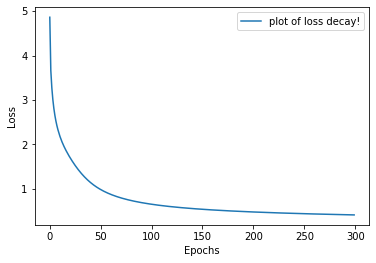

In [56]:
X = np.arange(0,300)
loss_array = np.array(losses)
plt.plot(X,loss_array, label = 'plot of loss decay!')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

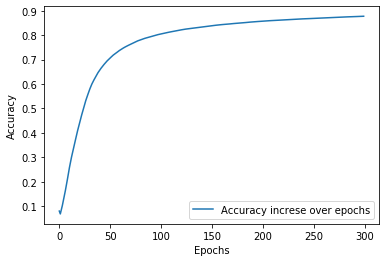

In [58]:
X = np.arange(0,300)
accuracy_array = np.array(accuracies)
plt.plot(X,accuracy_array,label='Accuracy increse over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Use your network on the test set and report the accuracy, you must get at least 70% accuracy on the test set.

In [73]:
calculate_accuracy(model.forward(data_test),target_test.T)

0.8839

Below you can add code cells and improve on the network structure as you see fit (it still must be an MLP), train and test your network and explain why it works better.


In [19]:
class MyMultiLayerPerceptron:
    def __init__(self,in_dim,hidden_dim_1,hidden_dim_2,out_dim):
        self.w1 = np.random.normal(size=(hidden_dim_1,in_dim)) * np.sqrt(1/hidden_dim_1)
        self.b1 = np.random.normal(size=(hidden_dim_1,1)) * np.sqrt(1/hidden_dim_1)
        
        self.w2 = np.random.normal(size=(hidden_dim_2,hidden_dim_1)) * np.sqrt(1/hidden_dim_2)
        self.b2 = np.random.normal(size=(hidden_dim_2,1))* np.sqrt(1/hidden_dim_2)
        
        self.w3 = np.random.normal(size=(out_dim,hidden_dim_2)) * np.sqrt(1/out_dim)
        self.b3 = np.random.normal(size=(out_dim,1)) * np.sqrt(1/out_dim)
    
    def forward(self,x):
        self.a0 = x.T
        
        self.z1 = self.w1 @ self.a0 + self.b1
        self.a1 = ReLU(self.z1)
        
        self.z2 = self.w2 @ self.a1 + self.b2
        self.a2 =ReLU(self.z2)
        
        self.z3 = self.w3 @ self.a2 + self.b3
        self.a3 = softmax(self.z3)
        
        self.prediction = self.a3
        return self.prediction
        
    def backward(self,Y_target):
        batch_size = Y_target.shape[1]
        dZ3 = self.a3 - Y_target
        self.w3_backward = (1./batch_size) * dZ3 @ self.a2.T
        self.b3_backward = (1./batch_size) * np.sum(dZ3)
        
        dA2 = self.w3.T @ dZ3
        dZ2 = dA2 * ReLU(self.z2,derivative=True)
        self.w2_backward = (1./batch_size) * dZ2 @ self.a1.T
        self.b2_backward = (1./batch_size) * np.sum(dZ2)
        
        dA1 = self.w2.T @ dZ2
        dZ1 = dA1 * ReLU(self.z1,derivative=True)
        self.w1_backward = (1./batch_size) * dZ1 @ self.a0.T
        self.b1_backward = (1./batch_size) * np.sum(dZ1)
        
    
    def step(self,lr,lam):
        self.w3 = self.w3 - (lr * self.w3_backward - self.w3*lam*lr)
        self.b3 = self.b3 - (lr * self.b3_backward - self.b3*lam*lr)
        
        self.w2 = self.w2 - (lr * self.w2_backward - self.w2*lam*lr)
        self.b2 = self.b2 - (lr * self.b2_backward - self.b2*lam*lr)
        
        self.w1 = self.w1 - (lr * self.w1_backward - self.w1*lam*lr)
        self.b1 = self.b1 - (lr * self.b1_backward - self.b1*lam*lr)
        
    def compute_loss(self,Y):
        Y_hat = self.prediction
        L_sum = np.sum(np.multiply(Y, np.log(Y_hat+1e-10)))
        m = Y.shape[1]
        L = -(1/m) * L_sum
        return L

In [39]:
model = MyMultiLayerPerceptron(28*28,128,64,10)
learning_rate = 0.6
regularization = 1e-3

epochs = 500
for i in range(epochs):
    model.forward(data_train)
    model.backward(target_train.T)
    model.step(learning_rate,regularization)
    
    if (i% 10 == 0) or (i == epochs-1):
        loss=model.compute_loss(target_train.T)
        accuracy=calculate_accuracy(model.prediction,target_train.T)
        print(f'Epoch: {i},Loss: {loss}, Accuracy: {accuracy}')

Epoch: 0,Loss: 3.0405598605498056, Accuracy: 0.12475
Epoch: 10,Loss: 2.182132743491792, Accuracy: 0.18021666666666666
Epoch: 20,Loss: 2.0805272448973597, Accuracy: 0.2123
Epoch: 30,Loss: 1.5393590195924447, Accuracy: 0.43538333333333334
Epoch: 40,Loss: 1.2099874590733721, Accuracy: 0.6348833333333334
Epoch: 50,Loss: 0.7402806838460576, Accuracy: 0.7523833333333333
Epoch: 60,Loss: 0.4968050612778894, Accuracy: 0.8418333333333333
Epoch: 70,Loss: 0.5727136865828855, Accuracy: 0.8055333333333333
Epoch: 80,Loss: 0.3143182293665256, Accuracy: 0.9069833333333334
Epoch: 90,Loss: 0.34748605531715215, Accuracy: 0.8938833333333334
Epoch: 100,Loss: 0.2679595155769922, Accuracy: 0.91955
Epoch: 110,Loss: 0.27539301486715534, Accuracy: 0.9154333333333333
Epoch: 120,Loss: 0.22627570422082674, Accuracy: 0.9320166666666667
Epoch: 130,Loss: 0.21145292500630974, Accuracy: 0.9362166666666667
Epoch: 140,Loss: 0.20292865814268066, Accuracy: 0.93845
Epoch: 150,Loss: 0.1976421306214987, Accuracy: 0.93976666666

In [41]:
calculate_accuracy(model.forward(data_test),target_test.T)

0.9643

#### Here I simply added a hidden layer to neural network and I've set it's size to 128 and I've initialized the network differently for better results. Neural Network layer and other paramaters are chosen by trial and error. 